In [31]:
from torch.utils.data import Dataset
import pyedflib
import numpy as np
from scipy.signal import spectrogram, welch
from xgboost import XGBClassifier, plot_tree
from sklearn import metrics
from chb_utils import parse_summary_file, parse_summary_file_chb24
import os
import random

In [32]:
class DataWindow:
    def __init__(self, record_id, record_file, start_index, end_index, label):
        self.record_id = record_id
        self.record_file = record_file
        self.start_index = start_index
        self.end_index = end_index
        self.label = label
        
    def get_data(self):
        with pyedflib.EdfReader(self.record_file) as f:
            channels = 23#f.signals_in_file
            size = self.end_index - self.start_index
            data = np.zeros((channels, size))
            for i in range(channels):
                data[i, :] = f.readSignal(i, self.start_index, size)
        return data

In [33]:
class ChbDataset(Dataset):
    def __init__(self, data_dir='./chb-mit-scalp-eeg-database-1.0.0/',
                 seizures_only=True,sample_rate=256,subject='chb01',mode='train',
                 window_length=5, preictal_length=300, sampler='all', welch_features=False): 
        ### other sampler option is "equal"
        'Initialization'
        self.sample_rate = sample_rate
        self.subject = subject
        self.data_dir = data_dir
        self.window_length = window_length
        self.preictal_length = preictal_length
        self.welch_features = welch_features
        self.sampler = sampler
        self.mode = mode
        self.record_type = 'RECORDS-WITH-SEIZURES' if seizures_only else 'RECORDS'
        self.records = None
        self.num_channels = None
        self.preictal = []
        self.ictal = []
        self.interictal = []
        self.windows = []
        random.seed(1000)
        self.get_records() 
        self.get_labeled_windows()
        self.get_windows_for_epoch()
        
    def get_records(self):
        with open(self.data_dir+self.record_type) as f:
            self.records = f.read().strip().splitlines()
            f.close()
            
        with open(self.data_dir+'RECORDS-WITH-SEIZURES') as f:
            self.labelled = f.read().strip().splitlines()
            f.close()
            
        #filter based on subject
        self.records = [record for record in self.records if self.subject in record]
        
        if self.mode == 'train':
            limit_file = 'TRAIN_RECORDS.txt'
        else:
            limit_file = 'TEST_RECORDS.txt'
        with open(limit_file) as f:
            limit_records = set(f.read().strip().splitlines())
            records = set(self.records)
        self.records = list(records - limit_records)
    
    def get_labeled_windows(self):
        summary_file = os.path.join(
            self.data_dir,
            self.subject,
            f"{self.subject}-summary.txt")
        if self.subject == 'chb24':
            all_records = parse_summary_file_chb24(summary_file)
        else:
            all_records = parse_summary_file(summary_file)
        num_channels = all_records[0].num_channels
        for record in all_records:
            assert record.num_channels == num_channels, f"Expected {num_channels} channels, found {record.num_channels}"
            if f"{self.subject}/{record.fileid}" in self.records:
                filename = os.path.join(self.data_dir, self.subject, record.fileid)
                prev_end = 0
                if record.duration is None:
                    duration = self.get_record_duration(filename)
                else:
                    duration = int(record.duration.total_seconds())
                end_of_file = duration * self.sample_rate
                if len(record.seizures) > 0:
                    seizures = []
                    for seizure in record.seizures:
                        preictal_start = max(self.sample_rate * (seizure.start_time - self.preictal_length), 0)
                        ictal_start = self.sample_rate * seizure.start_time
                        ictal_end = self.sample_rate * seizure.end_time
                        self.interictal.extend(self.create_windows_for_segment(
                            record.fileid, filename, prev_end, preictal_start, 0))
                        self.preictal.extend(self.create_windows_for_segment(
                            record.fileid, filename,preictal_start, ictal_start, 1))
                        self.ictal.extend(self.create_windows_for_segment(
                            record.fileid, filename, ictal_start, ictal_end, 2))
                        prev_end = ictal_end
                self.interictal.extend(self.create_windows_for_segment(
                        record.fileid, filename, prev_end, end_of_file, 0))
        self.num_channels = num_channels
                
    def get_record_duration(self, recordfile):
        with pyedflib.EdfReader(recordfile) as f:
            duration = f.file_duration
        return duration
        
    def create_windows_for_segment(self, recordid, recordfile, start_index, end_index, label):
        windows = []
        window_size = self.window_length * self.sample_rate
        for i in range(start_index, end_index - window_size + 1, window_size):
            windows.append(DataWindow(recordid, recordfile, i, i + window_size, label))
        return windows
                
    def get_windows_for_epoch(self):
        #print(self.sampler)
        if self.sampler == 'all':
            self.windows = self.interictal + self.preictal + self.ictal
        elif self.sampler == 'equal':
            num_samples = min([len(self.preictal), len(self.interictal), len(self.ictal)])
            self.windows = random.sample(self.interictal, num_samples) \
                        + random.sample(self.preictal, num_samples) \
                        + random.sample(self.ictal, num_samples)
            #print(len(self.windows))
        else:
            raise ValueError("Sampler must be all or equal")
            
    def __len__(self):
        'Denotes the total number of samples'
        if self.sampler == 'all':
            return len(self.preictal) + len(self.interictal) + len(self.ictal)
        elif self.sampler == 'equal':
            smallest = min([len(self.preictal), len(self.interictal), len(self.ictal)])
            return smallest * 3
        else:
            raise ValueError("Sampler must be all or equal")
        
    def __getitem__(self, index):
        'Generates one sample of data, which is one window of length window_length'
        # Select sample
        window = self.windows[index]
        data = window.get_data()
        label = window.label
        if self.welch_features:
            sample = self.__welch_features(data)
            data = sample.flatten()
        return data, label
    
    def all_data(self):
        data = [self.__getitem__(i) for i in range(len(self))]
        #print(data[0])
        allY = np.concatenate([[x[1] for x in data]])
        allX = np.array([x[0] for x in data])
        return allX,allY
    
    def __welch_features(self, sample):
        p_f, p_Sxx = welch(sample, fs=self.sample_rate, axis=1)
        p_SS = np.log1p(p_Sxx)
        arr = p_SS[:] / np.max(p_SS)
        return arr

In [44]:
class XGBoostTrainer:
    def __init__(self):
        self.model = XGBClassifier(objective='multi:softprob', learning_rate = 0.1,
              max_depth = 1, n_estimators = 330)
        self.subjects = ['chb0'+str(i) for i in range(1,10)] + ['chb' + str(i) for i in range(10,25)]
        self.preds = []
        self.labels = []
        
    def train_all(self):
        
        for subject in self.subjects:
            print('Training ' + subject)
            train = ChbDataset(mode='train',subject=subject, welch_features=True)
            tests = ChbDataset(mode='test' ,subject=subject, welch_features=True)
        
            allX,allY = train.all_data()
            
            self.model.fit(allX, allY)
            
            testX,testY = tests.all_data()

            preds = self.model.predict(testX)
            self.preds.append((preds))
            self.labels.append(testY)
                
            print(sum(preds==testY)/len(testY))

In [ ]:
run = True
if run:
    m = XGBoostTrainer()
    m.train_all()

subject = 'chb01'
    
train = ChbDataset(mode='train',subject=subject, welch_features=True)
tests = ChbDataset(mode='test' ,subject=subject, welch_features=True)


Training chb01
sample rate: 256
found 23 channels
found 42 edf files
sample rate: 256
found 23 channels
found 42 edf files
[13:09:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8688622754491018
Training chb02
sample rate: 256
found 23 channels
found 36 edf files
sample rate: 256
found 23 channels
found 36 edf files
[13:10:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7450549450549451
Training chb03
sample rate: 256
found 23 channels
found 38 edf files
sample rate: 256
found 23

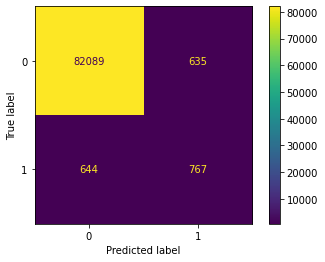

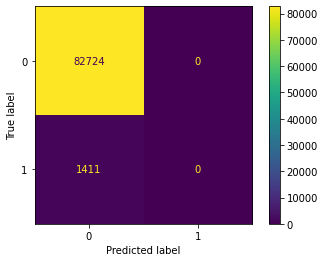

In [32]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay,roc_auc_score, f1_score,classification_report
#import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
if run:
    y_true = np.concatenate(m.labels)
    y_pred_class = np.concatenate(m.preds)

    y_pred_null = np.zeros_like(y_pred_class)

    cm = confusion_matrix(y_true, y_pred_class)
    cm2 = confusion_matrix(y_true, y_pred_null)
    tn, fp, fn, tp = cm.ravel()

    cm_display = ConfusionMatrixDisplay(cm).plot()
    cm_display2 = ConfusionMatrixDisplay(cm2).plot()

In [45]:
#fpr, tpr, _ = roc_curve(y_true, y_pred_class)#, pos_label=m.model.classes_[1])
#roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
if run:
    r = roc_auc_score(y_true,y_pred_class)
    r2 = roc_auc_score(y_true,y_pred_null)
    print(r,r2)

    fpr = fp/(fp+tn)
    print("False positives per day: " + str(fpr/((fp+tn)/256/60)*24))

0.7679549906478181 0.5
False positives per day: 0.03420685374800808


In [33]:
if run: 
    print(classification_report(y_true,y_pred_class))
    print(classification_report(y_true,y_pred_null))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99     82724
        True       0.55      0.54      0.55      1411

    accuracy                           0.98     84135
   macro avg       0.77      0.77      0.77     84135
weighted avg       0.98      0.98      0.98     84135

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     82724
        True       0.00      0.00      0.00      1411

    accuracy                           0.98     84135
   macro avg       0.49      0.50      0.50     84135
weighted avg       0.97      0.98      0.97     84135



c:\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
